<img src="../resources/cropped-SummerWorkshop_Header.png">  

<h1 align="center">Visual Behavior Neuropixels Workshop SWDB 2022 </h1> 
<h3 align="center">Tuesday, August 23rd, 2022</h3> 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<p>This notebook will introduce you to the Visual Behavior Neuropixels dataset and associated AllenSDK functions. 
    
<p> In the following sections, you will learn how to explore the Visual Behavior Neuropixels dataset to find a session of interest, load that session, and extract neurophysiological and behavioral data using the AllenSDK. Once you're familiar with the data, you will use it to answer two scientific questions: 
    <p> <b>How does image novelty impact:</b>
<p> &emsp;1) Visual responses in VISp?  
<p> &emsp;2) Mouse behavior during the change detection task?
    
<p> This tutorial will be split into two parts. In the first part, we'll learn the basics about the dimensions of the dataset and how to access session data. In the second part, we'll focus on answering our scientific questions.
    
### Session 1: Accessing/Understanding the data
* <a href='#Accessing-the-Dataset'>Accessing the Dataset</a>
* <a href='#Filtering-the-sessions-table-for-a-session-of-interest'>Filtering the sessions table for a session of interest</a>
* <a href='#Understanding-the-session-object'>Understanding the session object</a>
* <a href='#Exploring-the-Stimulus-Presentations-Table'>Exploring the Stimulus Presentations Table</a>
* <a href='#Exploring-the-Units-and-Channels-Tables'>Exploring the Units and Channels Tables</a> 
* <a href='#Getting-Spike-Times'>Getting Spike Times</a>
* <a href='#Understanding-the-Trials-Table'>Understanding the Trials Table</a>
* <a href='#Putting-it-all-together-to-make-a-change-triggered-PSTH-for-hit-trials'>Putting it all together to make a change-triggered PSTH for hit trials</a>
    
    
### Session 2:
* <a href='#Getting-reward,-pupil,-running-and-licking-data'>Getting reward, pupil, running and licking data</a>
* <a href='#Plotting-visual-responses-to-novel-and-familiar-images'>Plotting visual responses to novel and familiar images</a>
*<a href='#Calculating-hit-rates-for-novel-and-familiar-images'>Calculating hit rates for novel and familiar images</a>


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec #will use at the end
#Useful tool to arrange multiple plots in one figure (https://matplotlib.org/stable/api/_as_gen/matplotlib.gridspec.GridSpec.html)

%matplotlib inline

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
## Accessing the Dataset
    
<p>To answer our questions, we first need to access the data. The main entry point to the VBN dataset is the <code>VisualBehaviorNeuropixelsProjectCache</code> class.  This class is responsible for downloading any requested data or metadata as needed and storing it in well known locations.  For this workshop, all of the data has been preloaded onto the hard drives you have received, and is available on AWS.

<p>We begin by specifying our data cache directory. Then we'll import the <code>VisualBehaviorNeuropixelsProjectCache</code>  class and instantiate it.


In [2]:
import platform
platstring = platform.platform()

data_dirname = 'visual-behavior-neuropixels'
use_static = False
if 'Darwin' in platstring or 'macOS' in platstring:
    # macOS 
    data_root = "/Volumes/Brain2022/"
elif 'Windows'  in platstring:
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/"
elif ('amzn' in platstring):
    # then on AWS
    data_root = "/data/"
    data_dirname = 'visual-behavior-neuropixels-data'
    use_static = True
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/media/$USERNAME/Brain2022/"

In [3]:
from allensdk.brain_observatory.behavior.behavior_project_cache.\
    behavior_neuropixels_project_cache \
    import VisualBehaviorNeuropixelsProjectCache

In [4]:
# this path should point to the location of the dataset on your platform
cache_dir = os.path.join(data_root, data_dirname)

cache = VisualBehaviorNeuropixelsProjectCache.from_local_cache(
            cache_dir=cache_dir, use_static_cache=use_static)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
## Filtering the sessions table for a session of interest
    
<p>The <code>ecephys_sessions_table</code> contains metadata for every <b>Neuropixels recording session</b> in the dataset. This will be the main metadata table we'll use to filter sessions for analysis. Let's look at what's in it (note: you can find a short description of every column in the cheat sheet)

In [5]:
ecephys_sessions_table = cache.get_ecephys_session_table()
#ecephys_sessions_table = cache.get_ecephys_session_table(filter_abnormalities=false)
# the default is to filter out the abnormal sessions 
ecephys_sessions_table.head()

#session_set: either G or H, which each has 8 images, and two are in common
#

,behavior_session_id,date_of_acquisition,equipment_name,session_type,mouse_id,genotype,sex,project_code,age_in_days,unit_count,...,channel_count,structure_acronyms,image_set,prior_exposures_to_image_set,session_number,experience_level,prior_exposures_to_omissions,file_id,abnormal_histology,abnormal_activity
ecephys_session_id,,,,,,,,,,,,,,,,,,,,,
1052342277,1052374521,2020-09-23 15:34:18.179,NP.1,EPHYS_1_images_G_3uL_reward,530862,Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,M,NeuropixelVisualBehavior,148,1696.0,...,2304.0,"['APN', 'CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg...",G,32.0,1,Familiar,0.0,0,NaN,NaN
1051155866,1052162536,2020-09-17 15:05:39.665,NP.1,EPHYS_1_images_H_3uL_reward,524760,wt/wt,F,NeuropixelVisualBehavior,180,1922.0,...,2304.0,"['APN', 'CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg...",H,0.0,2,Novel,1.0,1,NaN,NaN
1052533639,1052572359,2020-09-24 15:12:13.229,NP.1,EPHYS_1_images_H_3uL_reward,530862,Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,M,NeuropixelVisualBehavior,149,1677.0,...,2304.0,"['APN', 'CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg...",H,0.0,2,Novel,1.0,4,NaN,NaN
1053925378,1053960984,2020-10-01 16:07:18.990,NP.0,EPHYS_1_images_H_3uL_reward,532246,Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,M,NeuropixelVisualBehavior,145,1823.0,...,2304.0,"['APN', 'CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg...",H,0.0,2,Novel,1.0,5,NaN,NaN
1053941483,1053960987,2020-10-01 17:03:58.362,NP.1,EPHYS_1_images_H_3uL_reward,527749,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,M,NeuropixelVisualBehavior,180,1543.0,...,2304.0,"['APN', 'CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg...",H,0.0,2,Novel,1.0,6,NaN,NaN


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

This table gives us lots of useful metadata about each recording session, including when the session took place, the `genotype`, `sex` and `age` of the mouse that was run, what brain areas were recorded and some important info about the stimulus. 

To demystify a few of these columns, let's briefly review the experimental design. Each mouse was trained with one of two image sets (`G` or `H`). The image set the mouse was trained with became highly familiar because each of the images was seen thousands of times. The image set the mouse was not trained with was observed for the first time during a Neuropixels recording session after the mouse had learned the task. 
    
For the majority of mice, we recorded two sessions: one with the trained `Familiar` image set and one with a `Novel` image set. Note that two of the eight images were shared across these two image sets as diagrammed below for an example mouse that was trained with image set `G`. 

<div>
<img src="https://brainmapportal-live-4cc80a57cd6e400d854-f7fdcae.divio-media.net/filer_public/f1/d1/f1d140bc-228a-4328-bdca-e3383a1a46f0/image_sets_and_training_trajectories_diagram_defaultsdk_and_unfiltered.png", width="900"/>
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

We can define each recording session by a few parameters in our sessions table, including the `image_set` used (`G` or `H`), the `experience_level` of the mouse (indicating whether the mouse had seen the image set in previous training sessions) and the `session_number` (indicating whether it was the first or second recording day for the mouse). Let's look at how many sessions we have of each type:

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    <p><b>Task 1.1:</b> How many <code>Novel</code> and <code>Familiar</code> sessions are there in the dataset (Hint: use the <code>experience_level</code> column)
</div>

In [6]:
#print('number of novel sessions')
#print(sum(ecephys_sessions_table.experience_level == 'Novel'))
#print('number of familiar sessions')
#print(sum(ecephys_sessions_table.experience_level == 'Familiar')) 

#use 'value_counts' function for tables to get summary data

ecephys_sessions_table.value_counts('experience_level')

experience_level
Novel       52
Familiar    51
dtype: int64

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    <p><b>Task 1.2:</b>  How many <code>G</code> and <code>H</code> sessions?
</div>

In [7]:
ecephys_sessions_table.value_counts('image_set')

image_set
H    52
G    51
dtype: int64

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Now let's count how many sessions were <code>Novel</code> or <code>Familiar</code> for each image set. (Hint: we can pass a list of column names to <code>value_counts</code>)
</div>

In [8]:
ecephys_sessions_table.value_counts(['image_set','experience_level'])

image_set  experience_level
H          Novel               42
G          Familiar            41
           Novel               10
H          Familiar            10
dtype: int64

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    <p><b>Task 1.3:</b>  Use the <code>genotype</code> column to print how many unique genotypes were used in this dataset. How many sessions from each genotype are there?
</div>

In [9]:
#print unique genotypes
ecephys_sessions_table.genotype.unique()

array(['Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt', 'wt/wt',
       'Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt'], dtype=object)

In [10]:
#print how many sessions for each
ecephys_sessions_table.value_counts('genotype')


genotype
Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt    43
wt/wt                                            38
Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt    22
dtype: int64

In [11]:
#Note we could also do this by using groupby
ecephys_sessions_table.groupby('genotype').count()['behavior_session_id']

genotype
Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt    43
Vip-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt    22
wt/wt                                            38
Name: behavior_session_id, dtype: int64

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

In addition to different types of image sets, this dataset contains ephys recording sessions from 3 genotypes (C57BL6J, VIP-IRES-CrexAi32 and SST-IRES-CrexAi32). 

For this tutorial, we need to select a session with:
- `Sst-IRES-Cre` mouse
- `Novel` images presented

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p><b>Task 1.4:</b>  Filter the <code>ecephys_sessions_table</code> for novel sessions and store the result in a new table called <code>novel_sessions</code>.
</div>

In [12]:
novel_session = ecephys_sessions_table[ecephys_sessions_table.experience_level == 'Novel']


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Now let's filter for novel sessions in Sst mice. (Hint, use both the <code>experience_level</code> and <code>genotype</code> columns). 
</div>

In [13]:
sst_novel_sessions = ecephys_sessions_table[(ecephys_sessions_table['genotype'].str.contains('Sst')) & 
                                            (ecephys_sessions_table['experience_level']=='Novel')]
sst_novel_sessions.head()

,behavior_session_id,date_of_acquisition,equipment_name,session_type,mouse_id,genotype,sex,project_code,age_in_days,unit_count,...,channel_count,structure_acronyms,image_set,prior_exposures_to_image_set,session_number,experience_level,prior_exposures_to_omissions,file_id,abnormal_histology,abnormal_activity
ecephys_session_id,,,,,,,,,,,,,,,,,,,,,
1053941483,1053960987,2020-10-01 17:03:58.362,NP.1,EPHYS_1_images_H_3uL_reward,527749,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,M,NeuropixelVisualBehavior,180,1543.0,...,2304.0,"['APN', 'CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg...",H,0.0,2,Novel,1.0,6,NaN,NaN
1064644573,1064666428,2020-11-19 15:18:01.372,NP.1,EPHYS_1_images_H_3uL_reward,544456,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,M,NeuropixelVisualBehavior,120,2254.0,...,2304.0,"['APN', 'CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg...",H,0.0,2,Novel,1.0,27,NaN,NaN
1048189115,1048221709,2020-09-03 14:16:57.913,NP.1,EPHYS_1_images_H_3uL_reward,509808,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,M,NeuropixelVisualBehavior,264,1925.0,...,2304.0,"['APN', 'CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg...",H,0.0,2,Novel,1.0,37,NaN,NaN
1048196054,1048222325,2020-09-03 14:25:07.290,NP.0,EPHYS_1_images_H_3uL_reward,524925,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,F,NeuropixelVisualBehavior,166,2288.0,...,2304.0,"['APN', 'CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg...",H,0.0,2,Novel,1.0,38,NaN,NaN
1065905010,1065929713,2020-11-24 14:21:48.847,NP.0,EPHYS_1_images_H_3uL_reward,544358,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,F,NeuropixelVisualBehavior,126,1998.0,...,2304.0,"['APN', 'CA1', 'CA3', 'DG-mo', 'DG-po', 'DG-sg...",H,0.0,2,Novel,1.0,39,NaN,NaN


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

## Understanding the session object

All data from a particular recording session is contained in the `ecephys_session` object. Let's load one of our novel, Sst sessions:

In [14]:
session_id = 1053941483
session = cache.get_ecephys_session(
            ecephys_session_id=session_id) #get all data that has the same session_id

/Users/christinejunhuiliu/opt/anaconda3/envs/swdb2022/lib/python3.8/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.4.0 because version 2.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


<div>
<img src="https://brainmapportal-live-4cc80a57cd6e400d854-f7fdcae.divio-media.net/filer_public/d2/4d/d24d67b2-59ee-4246-b4a4-621877ba9e5f/vbn_session_object_summary.png"/>
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

We can get a high-level summary of this session by accessing its `metadata` attribute:

In [15]:
session.metadata
# behavior_session_id: now only contains the ones that are during ephys recording, will have all the training session in later releases

{'equipment_name': 'NP.1',
 'sex': 'M',
 'age_in_days': 180,
 'stimulus_frame_rate': 60.0,
 'session_type': 'EPHYS_1_images_H_3uL_reward',
 'date_of_acquisition': datetime.datetime(2020, 10, 2, 0, 3, 58, tzinfo=tzutc()),
 'reporter_line': 'Ai32(RCL-ChR2(H134R)_EYFP)',
 'cre_line': 'Sst-IRES-Cre',
 'behavior_session_uuid': None,
 'driver_line': ['Sst-IRES-Cre'],
 'mouse_id': 527749,
 'full_genotype': 'Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt',
 'behavior_session_id': 1053960987,
 'ecephys_session_id': 1053941483}

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

### Exploring the Stimulus Presentations Table

The first step to analyzing how the mouse and its neurons responded to various stimuli is to understand which stimuli were presented at what time. For this, we use the `stimulus presentations` table, which is a dataframe containing info about each stimulus. You can find a description of each column in the cheat sheet. 

Every recording session consisted of three major visual stimulus epochs in the following order (diagrammed below):
- An active behavior session during which the mouse performed the change detection task
- Receptive field mapping and full-field flash stimuli
- Passive replay of stimulus shown during active behavior, but without the lickspout so the mouse can no longer respond.

<div>
<img src="https://brainmapportal-live-4cc80a57cd6e400d854-f7fdcae.divio-media.net/filer_public/84/46/84463f18-1b45-4f4d-854f-767fac4f7126/experimental_session_diagram.png", width="900"/>
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Let's look at the stimulus presentations table for the session we already loaded

In [16]:
stimulus_presentations = session.stimulus_presentations #this is a dataFrame
stimulus_presentations.head()

#stimulus_block

,active,color,contrast,duration,end_frame,flashes_since_change,image_name,is_change,omitted,orientation,...,position_y,rewarded,spatial_frequency,start_frame,start_time,stimulus_block,stimulus_index,stimulus_name,stop_time,temporal_frequency
stimulus_presentations_id,,,,,,,,,,,,,,,,,,,,,
0,True,NaN,NaN,0.250212,75,0.0,im104_r,False,False,NaN,...,NaN,False,NaN,60,25.254420,0,NaN,Natural_Images_Lum_Matched_set_ophys_H_2019,25.504632,NaN
1,True,NaN,NaN,0.250212,120,1.0,im104_r,False,False,NaN,...,NaN,False,NaN,105,26.005057,0,NaN,Natural_Images_Lum_Matched_set_ophys_H_2019,26.255269,NaN
2,True,NaN,NaN,0.250208,165,2.0,im104_r,False,False,NaN,...,NaN,False,NaN,150,26.755685,0,NaN,Natural_Images_Lum_Matched_set_ophys_H_2019,27.005892,NaN
3,True,NaN,NaN,0.250207,210,3.0,im104_r,False,False,NaN,...,NaN,False,NaN,195,27.506307,0,NaN,Natural_Images_Lum_Matched_set_ophys_H_2019,27.756515,NaN
4,True,NaN,NaN,0.250213,255,4.0,im104_r,False,False,NaN,...,NaN,False,NaN,240,28.256929,0,NaN,Natural_Images_Lum_Matched_set_ophys_H_2019,28.507142,NaN


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

This table is a record of every stimulus we presented to the mouse over the course of this experiment. The different stimuli are indexed by the `stimulus_block` column. Let's group this dataframe by stimulus block and see what stimulus was shown for each block.

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    <p><b>Task 2.1:</b>  Use the <code>groupby</code> method to group the stimulus_presentations table by <code>stimulus_block</code>. Then let's count the entries in each column for each stimulus block.
</div>

In [17]:
stimulus_block_grouped = stimulus_presentations.groupby('stimulus_block')
stimulus_block_grouped.count() #count all the non-nan values

,active,color,contrast,duration,end_frame,flashes_since_change,image_name,is_change,omitted,orientation,position_x,position_y,rewarded,spatial_frequency,start_frame,start_time,stimulus_index,stimulus_name,stop_time,temporal_frequency
stimulus_block,,,,,,,,,,,,,,,,,,,,
0,4804,0,0,4593,4804,4804,4804,4804,4804,0,0,0,4804,0,4804,4804,0,4804,4804,0
1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,1,1,0,1,1,0
2,3645,0,3645,3645,3645,0,0,0,0,3645,3645,3645,0,3645,3645,3645,3645,3645,3645,3645
3,1,0,0,1,1,0,0,0,0,0,0,0,0,0,1,1,0,1,1,0
4,150,150,150,150,150,0,0,0,0,0,0,0,0,0,150,150,150,150,150,0
5,4804,0,0,4804,4804,4804,4804,4804,4804,0,0,0,4804,0,4804,4804,0,4804,4804,0


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Let's look at the first row for each block (Hint, you can use <code>.head(1)</code> to get the first row)
</div>

In [18]:
stimulus_block_grouped.head(1).reset_index()
#block 0 = active behavior portion
#block 0 and 5 = only ones that presented pictures

#just showing the first trial of 

,stimulus_presentations_id,active,color,contrast,duration,end_frame,flashes_since_change,image_name,is_change,omitted,...,position_y,rewarded,spatial_frequency,start_frame,start_time,stimulus_block,stimulus_index,stimulus_name,stop_time,temporal_frequency
0,0,True,NaN,NaN,0.250212,75,0.0,im104_r,False,False,...,NaN,False,NaN,60,25.254420,0,NaN,Natural_Images_Lum_Matched_set_ophys_H_2019,25.504632,NaN
1,4804,False,NaN,NaN,10.008400,216914,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,216314,3660.861634,1,NaN,spontaneous,3670.870034,NaN
2,4805,False,NaN,0.8,0.250213,216929,NaN,NaN,NaN,NaN,...,-40.0,NaN,0.08,216914,3670.870034,2,0.0,gabor_20_deg_250ms,3671.120247,4.0
3,8450,False,NaN,NaN,288.991867,288914,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,271589,4582.883348,3,NaN,spontaneous,4871.875214,NaN
4,8451,False,1.0,0.8,0.250213,288929,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,288914,4871.875214,4,1.0,flash_250ms,4872.125427,NaN
5,8601,False,NaN,NaN,0.250201,307589,0.0,im104_r,False,False,...,NaN,False,NaN,307574,5195.429343,5,NaN,Natural_Images_Lum_Matched_set_ophys_H_2019,5195.679544,NaN


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

This shows us the structure of this experiment (and every experiment in this dataset). There are 5 stimulus blocks as follows:

**block 0**: Change detection task. Natural images are flashed repeatedly and the mouse is rewarded for licking when the identity of the image changes. You can find more info about this task [here](http://portal.brain-map.org/explore/circuits/visual-behavior-neuropixels?edit&language=en).

**block 1**: Brief gray screen (10 seconds)

**block 2**: Receptive field mapping using gabor stimuli. For more details on this stimulus consult [this notebook](https://allensdk.readthedocs.io/en/latest/_static/examples/nb/ecephys_receptive_fields.html).

**block 3**: Longer gray screen (5 minutes)

**block 4**: Full-field flashes, shown at 80% contrast. Flashes can be black (color = -1) or white (color = 1). This stimulus is useful for calculating response latencies and current source density analysis for layer identification.

**block 5**: Passive replay. Frame-for-frame replay of the stimulus shown during the change detection task (block 0), but now with the lick spout retracted so the animal can no longer engage in the task.

    
For now, we will focus on block 0 and 5, the active behavior and the passive replay of the same images.

Let's confirm that the active behavior block (0) and the passive replay block (5) match frame for frame:

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    <p><b>Task 2.2:</b>  How many unique images were shown during this session (Hint: use the <code>image_name</code> column)? 
</div>

In [19]:
# get unique images
stimulus_presentations.image_name.unique()

array(['im104_r', 'omitted', 'im087_r', 'im111_r', 'im005_r', 'im034_r',
       'im083_r', 'im024_r', 'im114_r', nan], dtype=object)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    <p><b>Task 2.3:</b> How many image changes were there (Hint: use the <code>is_change</code> column)? What if you limit the count to the active behavior session?
</div>

In [20]:
#total image changes

print('all image changes:')
print(sum(stimulus_presentations.is_change))



all image changes:
nan


In [21]:
# image changes during active behavior
print('active portion image change:')
print(sum(stimulus_presentations.is_change[stimulus_presentations.stimulus_block == 0]))

active portion image change:
298


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

### Exploring the Units and Channels Tables

We'll use the units and channels tables to get info about each unit recorded during the session. These tables will help us filter the data for units in a particular brain region or for units that meet specific quality criteria. You can find a description of the columns in these dataframes in our cheat sheet.

### Units table

This table contains quality metrics and waveform metrics for every unit recorded during this session:

In [22]:
units = session.get_units()
units.head()
#index is a unique ID of the unit

,PT_ratio,amplitude,amplitude_cutoff,cluster_id,cumulative_drift,d_prime,firing_rate,isi_violations,isolation_distance,l_ratio,...,presence_ratio,quality,recovery_slope,repolarization_slope,silhouette_score,snr,spread,velocity_above,velocity_below,waveform_duration
id,,,,,,,,,,,,,,,,,,,,,
1061853767,0.738222,632.394165,0.000008,23,79.63,10.843623,68.687706,0.000167,246.203332,3.104812e-08,...,0.99,good,-0.808696,2.795432,0.113092,4.519657,60.0,0.686767,0.137353,0.206030
1061853941,0.490965,207.990510,0.273518,196,347.89,3.966892,1.747814,0.374140,60.672055,3.726235e-03,...,0.99,good,-0.112609,0.618665,0.099188,2.541619,70.0,0.480737,0.206030,0.618090
1061853761,0.538560,284.645010,0.475406,17,188.14,4.841153,5.819598,0.010472,74.209946,8.290955e-04,...,0.99,good,-0.312478,1.265120,0.093662,2.558605,60.0,0.343384,-1.098827,0.233501
1061853892,2.714716,180.353940,0.500000,147,1289.78,6.065760,2.396936,0.157757,88.232357,5.768766e-04,...,0.99,good,-0.066549,0.654593,0.051338,2.419777,40.0,-0.343384,-0.686767,0.425796
1061853891,1.105938,533.637585,0.000136,146,474.71,8.037788,2.563054,0.000000,147.532935,7.581718e-08,...,0.99,good,-1.241809,1.728842,0.159304,5.942894,50.0,-0.068677,0.686767,0.151089


In [23]:
units.columns

Index(['PT_ratio', 'amplitude', 'amplitude_cutoff', 'cluster_id',
       'cumulative_drift', 'd_prime', 'firing_rate', 'isi_violations',
       'isolation_distance', 'l_ratio', 'local_index', 'max_drift',
       'nn_hit_rate', 'nn_miss_rate', 'peak_channel_id', 'presence_ratio',
       'quality', 'recovery_slope', 'repolarization_slope', 'silhouette_score',
       'snr', 'spread', 'velocity_above', 'velocity_below',
       'waveform_duration'],
      dtype='object')

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

For more information about many of the metrics included in this table and how to use them to guide your analysis, see our [quality metrics tutorial](https://allensdk--2471.org.readthedocs.build/en/2471/_static/examples/nb/visual_behavior_neuropixels_quality_metrics.html). For now, here's a brief description of each column:

**INDEX**: Unique identifier for each unit. This will be the key to the session waveforms, spike_amplitudes and spike_times dictionaries.

**Waveform metrics**: Look [here](https://github.com/AllenInstitute/ecephys_spike_sorting/tree/master/ecephys_spike_sorting/modules/mean_waveforms) for more detail on these metrics and the code that computes them. For the below descriptions the '1D waveform' is defined as the waveform on the peak channel. The '2D waveform' is the waveform across channels centered on the peak channel.

`peak_channel_id`:                      channel ID for the channel on which unit's waveform had the largest amplitude  
`amplitude`:                            Peak to trough amplitude for mean 1D waveform in microvolts   
`waveform_duration`:                    Time from trough to peak for 1D waveform in milliseconds     
`waveform_halfwidth`:                   Width of 1D waveform at half-amplitude in milliseconds  
`PT_ratio`:                             Ratio of the max (peak) to the min (trough) amplitudes for 1D waveform  
`recovery_slope`:                       Slope of recovery of 1D waveform to baseline after repolarization (coming down from peak)  
`repolarization_slope`:                 Slope of repolarization of 1D waveform to baseline after trough  
`spread`:                               Distance in microns along the shank of probe for which the spike amplitude was above 12% of the peak channel amplitude  
`velocity_above`:                       Slope of spike propagation velocity traveling in dorsal direction from soma (note to avoid infinite values, this is actaully the inverse of velocity: ms/mm)  
`velocity_below`:                       Slope of spike propagation velocity traveling in ventral direction from soma (note to avoid infinite values, this is actually the inverse of velocity: ms/mm)  
`snr`:                                  signal-to-noise ratio for 1D waveform        


**Quality metrics**: Look [here](https://github.com/AllenInstitute/ecephys_spike_sorting/tree/7e567a6fc3fd2fc0eedef750b83b8b8a0d469544/ecephys_spike_sorting/modules/quality_metrics) for more detail on these metrics and the code that computes them.

`amplitude_cutoff`:                     estimate of miss rate based on amplitude histogram (ie fraction of spikes estimated to have been below detection threshold)  
`cumulative_drift`:                     cumulative change in spike depth along probe throughout the recording  
`max_drift`:                            Maximum change in unit depth across recording  
`d_prime`:                              classification accuracy based on LDA  
`firing_rate`:                          Mean firing rate over entire recording  
`isi_violations`:                       Ratio of refractory violation rate to total spike rate  
`isolation_distance`:                   Distance to nearest cluster in Mahalanobis space   
`l_ratio`:                              The Mahalanobis distance and chi-squared inverse cdf are used to find the probability of cluster membership for each spike.  
`nn_hit_rate`:                          Fraction of nearest neighbors in PCA space for spikes in unit cluster that are also in unit cluster  
`nn_miss_rate`:                         Fraction of nearest neighbors for spikes outside unit cluster than are in unit cluster  
`presence_ratio`:                       Fraction of time during session for which a unit was spiking  
`silhouette_score`:                     Standard metric for cluster overlap, computed in PCA space    
`quality`:                              Label assigned based on waveform shape as described [here](https://github.com/AllenInstitute/ecephys_spike_sorting/tree/7e567a6fc3fd2fc0eedef750b83b8b8a0d469544/ecephys_spike_sorting/modules/noise_templates). Either 'good' for physiological waveforms or 'noise' for artifactual waveforms.



<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    <p><b>Task 3.1:</b> Plot a histogram of <code>waveform_duration</code> across all units. What happens when you restrict the data to only units with <code>quality == 'good'</code>? Be sure to label your axes.
</div>

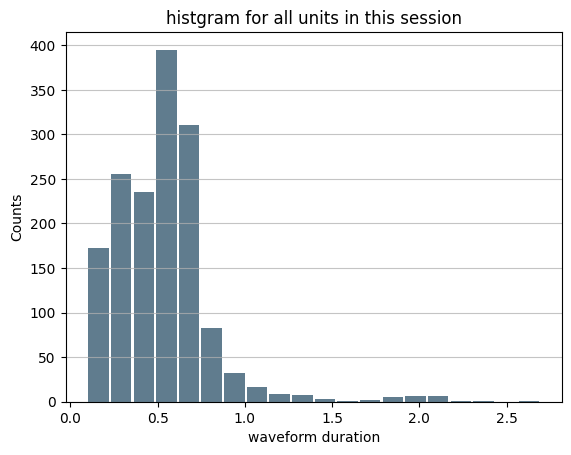

In [24]:
#Histogram across all units
units.waveform_duration.plot.hist(bins=20, rwidth=0.9,
                   color='#607c8e')
plt.title('histgram for all units in this session')
plt.xlabel('waveform duration')
plt.ylabel('Counts')
plt.grid(axis='y', alpha=0.75)

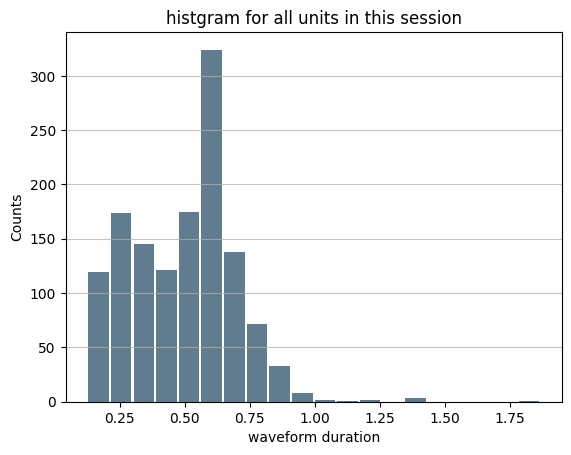

In [25]:
#Only 'good' units
#Histogram across all units
units[units.quality == 'good'].waveform_duration.plot.hist(bins=20, rwidth=0.9,
                   color='#607c8e')
plt.title('histgram for all units in this session')
plt.xlabel('waveform duration')
plt.ylabel('Counts')
plt.grid(axis='y', alpha=0.75)


### Channels Table
This table contains info about where each channel was in the brain as well as it's relative position along the probe.

In [26]:
channels = session.get_channels()
channels.head(3)

,anterior_posterior_ccf_coordinate,dorsal_ventral_ccf_coordinate,filtering,left_right_ccf_coordinate,probe_channel_number,probe_horizontal_position,probe_id,probe_vertical_position,structure_acronym
id,,,,,,,,,
1061851368,8315.0,4024.0,AP band: 500 Hz high-pass; LFP band: 1000 Hz l...,6882.0,0,43,1054059289,20,APN
1061851369,8313.0,4014.0,AP band: 500 Hz high-pass; LFP band: 1000 Hz l...,6886.0,1,11,1054059289,20,APN
1061851370,8311.0,4004.0,AP band: 500 Hz high-pass; LFP band: 1000 Hz l...,6889.0,2,59,1054059289,40,APN


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

**INDEX**: Unique identifier for each channel. This is the id used in the units `peak_channel_id` column.  
    
**General Metadata**  

`anterior_posterior_ccf_coordinate`:    CCF coord in the AP axis  
`dorsal_ventral_ccf_coordinate`:        CCF coord in the DV axis  
`left_right_ccf_coordinate`:            CCF coord in the left/right axis  
`structure_acronym`:                    CCF acronym for area to which unit was assigned  
`structure_id`:                         CCF structure ID for the area to which unit was assigned  
`probe_horizontal_position`:            Horizontal (perpindicular to shank) probe position of each unit's peak channel in microns  
`probe_vertical_position`:              Vertical (along shank) probe position of each unit's peak channel in microns  
`probe_channel_number`:                 Index of channel position on probe (0-383 with 0 at tip of probe)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Because we will want to use info from both the units table and the channels table to filter our units, we can merge them into one table with all of the relevant columns. This merged table will include quality metrics and CCF locations for every unit. For example, we can use it to see which brain regions were recorded during this session:

In [27]:
units = units.merge(channels, left_on='peak_channel_id', right_index=True)

units.columns

Index(['PT_ratio', 'amplitude', 'amplitude_cutoff', 'cluster_id',
       'cumulative_drift', 'd_prime', 'firing_rate', 'isi_violations',
       'isolation_distance', 'l_ratio', 'local_index', 'max_drift',
       'nn_hit_rate', 'nn_miss_rate', 'peak_channel_id', 'presence_ratio',
       'quality', 'recovery_slope', 'repolarization_slope', 'silhouette_score',
       'snr', 'spread', 'velocity_above', 'velocity_below',
       'waveform_duration', 'anterior_posterior_ccf_coordinate',
       'dorsal_ventral_ccf_coordinate', 'filtering',
       'left_right_ccf_coordinate', 'probe_channel_number',
       'probe_horizontal_position', 'probe_id', 'probe_vertical_position',
       'structure_acronym'],
      dtype='object')

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Now we can use the merged units/channels table to show how many units were recorded in each brain area for this session. (Hint: use the <code>structure_acronym</code> column)
</div>

In [28]:
units.value_counts('structure_acronym')

structure_acronym
CA1      269
APN      170
VISpm    135
POL      109
VISal     84
LP        75
VISp      75
VISrl     74
DG        72
MGv       70
VISl      69
CA3       67
VISam     60
SUB       34
LGv       34
ZI        30
PIL       27
MRN       25
MB        21
TH        13
MGm        8
MGd        8
PoT        6
SGN        5
DT         3
dtype: int64

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

### Getting Spike Times
    
The spike times for every unit are stored in a dictionary called <code>spike_times</code>. The keys for this dictionary are the unit_ids (the index values for the units table).

In [29]:
spike_times = session.spike_times
list(spike_times.keys())[:10]

[1061853767,
 1061853941,
 1061853761,
 1061853892,
 1061853891,
 1061853885,
 1061853809,
 1061853958,
 1061853946,
 1061853757]

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Let's grab the spike times for the first unit in this list

In [30]:
unit_spikes = spike_times[1061853767]
#put unit ID and get all the spike times for this unit in secs re:experiment clock
print(unit_spikes[:20])

[4.02294146 4.02470812 4.02677479 4.02880813 4.03397479 4.04140813
 4.04354146 4.0634748  4.06940814 4.07184147 4.11887482 4.12180816
 4.12390816 4.12577482 4.12760816 4.12970816 4.13177483 4.1464415
 4.1489415  4.1535415 ]


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    <p><b>Task 3.2:</b> Plot a raster of the spike times for unit 1061853810 over the first minute of the recording. Where is this unit located? Put the unit id and the brain region in the plot title.
</div>

In [31]:
#Get the brain region for this unit (remember the column with this info is called 'structure_acronym')
unit_region = units.loc[1061853810].structure_acronym

In [32]:
#Get spike times for this unit
unit_spikes = spike_times[1061853810]

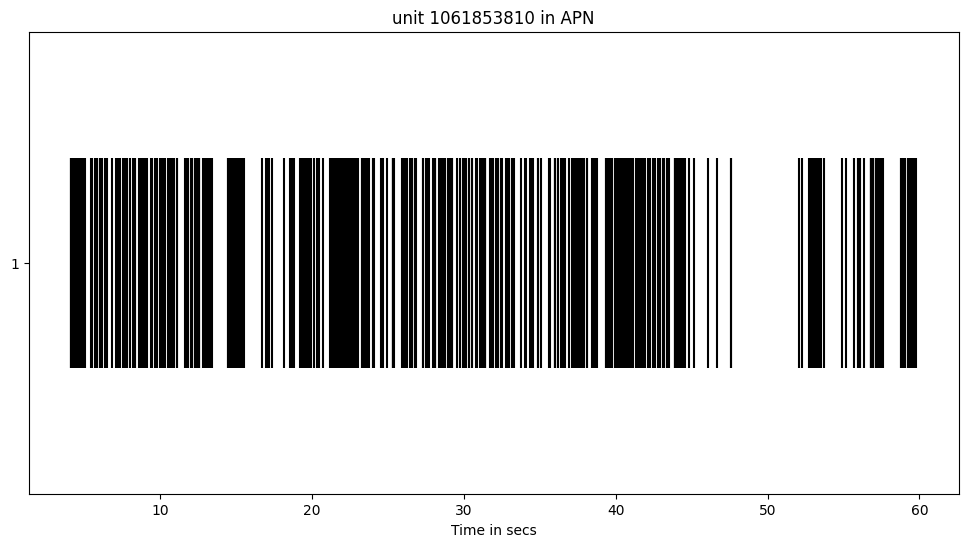

In [33]:
#Plot the raster for the first 60 seconds (Hint: you can use matplotlibs "eventplot" to efficiently 
#plot spike rasters: ax.eventplot(times_to_plot) )
fig, ax = plt.subplots()
fig.set_size_inches(12,6)
unitID= 1061853810
ax.eventplot(unit_spikes[unit_spikes<60], color='k')

ax.set_title(f"unit {unitID} in {unit_region}")
ax.set_xlabel('Time in secs')
ax.set_yticks([1])


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

### Getting Spike Waveforms
    
The waveform for each unit across all recording channels is stored in the <code>session</code> object as a dictionary called <code>mean_waveforms</code>. The keys to this dictionary are the unit ids. Let's grab the waveform for this unit and plot it.

In [34]:
waveforms = session.mean_waveforms
# waveforms is dictionary, with unit ID as index

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    <p><b>Task 3.3:</b> Grab the waveform for unit 1061853810. What shape is the array?
</div>

In [35]:
session.probes # meta data for the probes: sampling rate close to 30kHz 

,name,location,sampling_rate,lfp_sampling_rate,has_lfp_data
id,,,,,
1054059289,probeA,See electrode locations,29999.989984,None,False
1054059290,probeB,See electrode locations,30000.192207,None,False
1054059291,probeC,See electrode locations,30000.062933,None,False
1054059292,probeD,See electrode locations,29999.931329,None,False
1054059293,probeE,See electrode locations,30000.089296,None,False
1054059294,probeF,See electrode locations,29999.971244,None,False


In [36]:
# get waveform
unit_waveform = waveforms[1061853810]

# get shape
unit_waveform.shape 
# 384 channels (get all the channels in the probe)
# 82 samples (sampling rate of )


(384, 82)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    <p><b>Task 3.5:</b> Plot the 2D waveform as an image (Hint: use <code>imshow</code>. Does where it appears on the probe make sense given the brain region (APN is in the midbrain)?
</div>

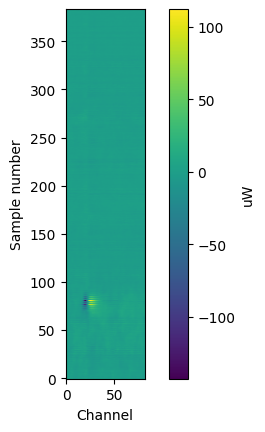

In [37]:
fig, ax= plt.subplots()
im = ax.imshow(unit_waveform, origin = 'lower') #origin allows you to show 0 from the bottom
ax.set_ylabel('Sample number')
ax.set_xlabel('Channel')
plt.colorbar(im,label='uW')

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Let's zoom in on the relevant section of the probe. We can use the column `probe_channel_number` to get the index of the channel on the probe where the waveform has the largest amplitude.
</div>

In [38]:
peak_channel = units.loc[1061853810]['probe_channel_number']
peak_channel

81

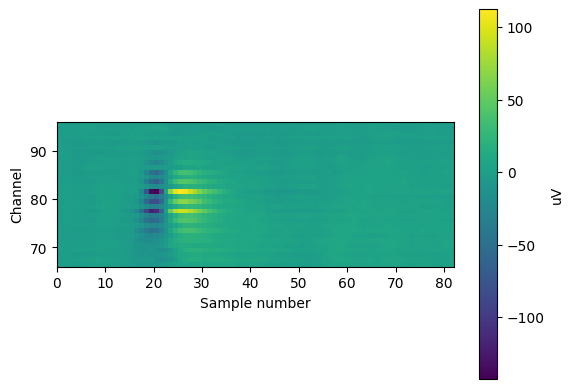

In [39]:
fig, ax = plt.subplots()
im = ax.imshow(unit_waveform[peak_channel-15:peak_channel+15], origin='lower', 
               extent=[0, 82, peak_channel-15, peak_channel+15]) 
# to zoom in 
ax.set_xlabel('Sample number')
ax.set_ylabel('Channel')
plt.colorbar(im, label='uV')

# jagget bc the channel probes are staggered

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Now let's plot the 1D waveform on the peak channel for this unit. We'll convert the x-axis units from samples to time (remember the sampling rate was 30 kHz). Compare what you see in this plot to the waveform metrics in the units table for this unit.
</div>

Text(0, 0.5, 'uV')

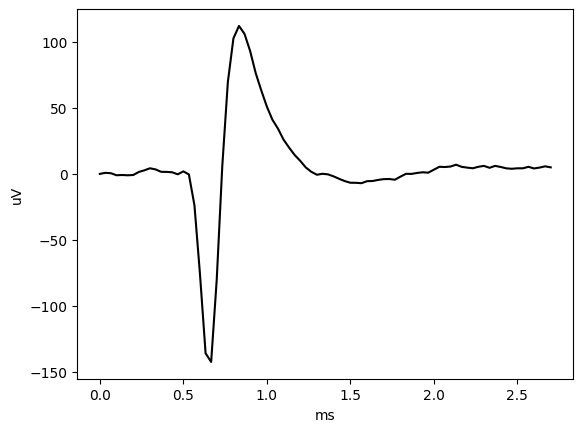

In [40]:
#now get the waveform on this channel
unit_peak_waveform = unit_waveform[peak_channel]

#make a time vector for your x axis
waveform_time = np.arange(unit_peak_waveform.size)/30.

#now plot the waveform
fig, ax = plt.subplots()
ax.plot(waveform_time, unit_peak_waveform, 'k')
ax.set_xlabel('ms')
ax.set_ylabel('uV')

# this is a midbraim fast spiking waveform

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

How do the waveform metrics in the metrics table for this unit compare to what we see in this plot?
</div>

In [41]:
print(units.loc[1061853810][['waveform_duration', 'PT_ratio', 'amplitude']])

#use .loc to index 
#PT_ratio: peak to trough ratio
#amplitude = total amplitude from trough to peak

waveform_duration     0.178559
PT_ratio               0.69187
amplitude            254.60409
Name: 1061853810, dtype: object


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

## Understanding the Trials Table
       
Let's briefly review the timing of the change detection task (`stimulus_block` 0 or the `active` portion of the stimulus table). Remember the mouse is rewarded for licking to changes in the identity of a flashing natural image. 

* Each flash is 250 ms long with 500 ms of gray screen between images (ie, 750 ms from the start of flash *n* to the start of flash *n+1*). 

* Mice are rewarded for licking within a reward window defined as 150-750 ms after an image change. 

* Licks before the change abort the trial, and a new trial begins

* 5% of flashes can be omitted with the exception of 1) the flash immediately following an omission and 2) the flash immediately preceding a change which can't be omitted.

<img src="https://brainmapportal-live-4cc80a57cd6e400d854-f7fdcae.divio-media.net/filer_public/e7/de/e7de5da4-a19f-4ef6-9bc3-3a5b088048ac/task_diagram.png"/>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

There are 5 possible ways each trial can be classified. Having a solid understanding of what these mean is vital to interpreting this data, so make sure you understand the diagram below and please ask questions if you're uncertain about anything:

<img src="https://brainmapportal-live-4cc80a57cd6e400d854-f7fdcae.divio-media.net/filer_public/30/91/30919450-3121-4629-bf25-d2ab9e4f8b0d/doc_trial_classification_diagram.png"/>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Now let's explore the behavior trials table. This table contains lots of useful information about every trial in the change detection task.

In [42]:
trials = session.trials
trials.head()

# change time is the time that the task computer says "switch"
# use the time from the stimulus presentation table to get the correct time for when the mouse 
# would be seeing the  change
# every row is each trial 

#initial_image_name = change_image_name: catch trial
# stimulus_change and 'catch' is only true if the mouse actually makes it to the change phase, 
# even in the intended catch trials

,start_time,stop_time,initial_image_name,change_image_name,stimulus_change,change_time_no_display_delay,go,catch,lick_times,response_time,reward_time,reward_volume,hit,false_alarm,miss,correct_reject,aborted,auto_rewarded,change_frame,trial_length
trials_id,,,,,,,,,,,,,,,,,,,,
0,25.20983,26.19343,im104_r,im104_r,False,NaN,False,False,"[25.72637, 25.87602]",NaN,NaN,0.0,False,False,False,False,True,False,NaN,0.98360
1,26.71046,28.34528,im104_r,im104_r,False,NaN,False,False,[28.02817],NaN,NaN,0.0,False,False,False,False,True,False,NaN,1.63482
2,28.96234,32.73245,im104_r,im104_r,False,NaN,False,False,[32.39844],NaN,NaN,0.0,False,False,False,False,True,False,NaN,3.77011
3,33.46618,35.85175,im104_r,im104_r,False,NaN,False,False,[35.53463],NaN,NaN,0.0,False,False,False,False,True,False,NaN,2.38557
4,36.46863,39.62138,im104_r,im104_r,False,NaN,False,False,"[39.15441, 39.28716]",NaN,NaN,0.0,False,False,False,False,True,False,NaN,3.15275


In [43]:
trials.columns

Index(['start_time', 'stop_time', 'initial_image_name', 'change_image_name',
       'stimulus_change', 'change_time_no_display_delay', 'go', 'catch',
       'lick_times', 'response_time', 'reward_time', 'reward_volume', 'hit',
       'false_alarm', 'miss', 'correct_reject', 'aborted', 'auto_rewarded',
       'change_frame', 'trial_length'],
      dtype='object')

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Unlike the stimulus presentations table in which every row corresponded to a visual stimulus presentation, for the behavior trials table every row corresponds to one trial of the change detection task. Here is a quick summary of the columns:

`start_time`: Experiment time when this trial began in seconds.

`stop_time`: Experiment time when this trial ended.

`initial_image_name`: Indicates which image was shown before the change (or sham change) for this trial

`change_image_name`: Indicates which image was scheduled to be the change image for this trial. Note that if the trial is aborted, a new trial will begin before this change occurs.

`stimulus_change`: Indicates whether an image change occurred for this trial. 

`change_time_no_display_delay`: Experiment time when the task-control computer commanded an image change or sham change. This change time is used to determine the response window during which a lick will trigger a reward. Note that due to display lag, this is not the time when the change image actually appears on the screen. To get this time, you need the stimulus_presentations table (more about this below).

`go`: Indicates whether this trial was a 'go' trial. To qualify as a go trial, an image change must occur and the trial cannot be autorewarded.

`catch`: Indicates whether this trial was a 'catch' trial. To qualify as a catch trial, a 'sham' change must occur during which the image identity does not change. These sham changes are drawn to match the timing distribution of real changes and can be used to calculate the false alarm rate.

`lick_times`: A list indicating when the behavioral control computer recognized a lick. Note that the control computer records events at the stimulus refresh rate (60 Hz). Therefore these times are not identical to the lick times from the licks dataframe, which record when the licks were registered by the lick sensor, which is sampled at a much higher rate (100 kHz). The licks dataframe should generally be used for analysis of the licking behavior rather than these times.

`response_time`: Indicates the time when the first lick was registered by the task control software for trials that were not aborted (go or catch). NaN for aborted trials. For a more accurate measure of response time, the licks dataframe should be used.

`reward_time`: Indicates when the reward command was triggered for hit trials. NaN for other trial types. 

`reward_volume`: Indicates the volume of water dispensed as reward for this trial. 

`hit`: Indicates whether this trial was a 'hit' trial. To qualify as a hit, the trial must be a go trial during which the stimulus changed and the mouse licked within the response window (150-750 ms after the change time).

`false_alarm`: Indicates whether this trial was a 'false alarm' trial. To qualify as a false alarm, the trial must be a catch trial during which a sham change occurred and the mouse licked during the response window.

`miss`: To qualify as a miss trial, the trial must be a go trial during which the stimulus changed but the mouse did not lick within the response window.

`correct_reject`: To qualify as a correct reject trial, the trial must be a catch trial during which a sham change occurred and the mouse withheld licking.

`aborted`: A trial is aborted when the mouse licks before the scheduled change or sham change. On these trials, the change (sham change) never occurs and, instead, a new trial begins.

`auto_rewarded`: During autorewarded trials, the reward is automatically triggered after the change regardless of whether the mouse licked within the response window. These always come at the beginning of the session to help engage the mouse in behavior.

`change_frame`: Indicates the stimulus frame index when the change (on go trials) or sham change (on catch trials) occurred. 

`trial_length`: Duration of the entire trial in seconds.

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    <p><b>Task 4.1:</b> How many go trials were there during this session? How many were hits? Use these values to calculate the overall hit rate.
</div>

In [44]:
# Get number of go trials
num_go = sum(trials.go)

In [45]:
# Get number of hits
num_hit = sum(trials.hit)

In [46]:
# Get hit rate
hit_rate = num_hit/num_go
hit_rate

0.4711864406779661

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

## Putting it all together to make a change-triggered PSTH for hit trials

#### Understanding the Peri-stimulus-time histogram
<img src=https://neuronaldynamics.epfl.ch/online/x187.png>

K is the number of trials   
&Delta;t is the time bin width  
n<sub>k</sub>(t; t + &Delta;t) is the total count of spikes across trials in that time bin

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Let's make a PSTH aligned on the change times for the first 20 hit trials. To find these times, we'll need to combine information from the trials table and the stimulus_presentations table as follows:
        <p>1) Get the first 20 hit trials from the trials dataframe.
        <p>2) Find what stimulus frame the change for these trials occurred on.
        <p>3) Find the flashes (rows) in the stimulus_presentations table that started on these same frames (use the <code>start_frame</code> column).
    <p>4) Get the <code>start_time</code> for these flashes. These are the times we're looking for.
</div>

In [47]:
# grab the first 20 hit trials. To do this we'll use iloc to index the trials dataframe 
# by position
first_20_hits = trials[trials.hit].iloc[:20]
first_20_hits.head()

,start_time,stop_time,initial_image_name,change_image_name,stimulus_change,change_time_no_display_delay,go,catch,lick_times,response_time,reward_time,reward_volume,hit,false_alarm,miss,correct_reject,aborted,auto_rewarded,change_frame,trial_length
trials_id,,,,,,,,,,,,,,,,,,,,
26,111.53134,123.29171,im111_r,im104_r,True,119.03784,True,False,"[119.55534, 119.70437, 120.48827, 120.68841, 1...",119.55534,119.55534,0.003,True,False,False,False,False,False,5685.0,11.76037
28,126.54407,133.83337,im104_r,im005_r,True,129.54671,True,False,"[130.28088, 130.81353, 130.94707, 131.0805, 13...",130.28088,130.28088,0.003,True,False,False,False,False,False,6315.0,7.28930
29,134.05003,143.57470,im005_r,im034_r,True,139.30535,True,False,"[139.80542, 139.93793, 140.07157, 140.17142, 1...",139.80542,139.80542,0.003,True,False,False,False,False,False,6900.0,9.52467
34,161.07253,170.61417,im111_r,im034_r,True,166.32763,True,False,"[166.74467, 166.87711, 167.02716, 167.14395, 1...",166.74467,166.74467,0.003,True,False,False,False,False,False,8520.0,9.54164
37,176.08527,183.35841,im034_r,im087_r,True,179.08806,True,False,"[179.57194, 179.68808, 179.80451, 179.90462, 1...",179.57194,179.57194,0.003,True,False,False,False,False,False,9285.0,7.27314


In [48]:
#Get the change frames for these trials
change_frames = first_20_hits.change_frame.values
change_frames

array([ 5685.,  6315.,  6900.,  8520.,  9285.,  9960., 12076., 14597.,
       15587., 16847., 17297., 18422., 18917., 20312., 21662., 23237.,
       23777., 24452., 26252., 26883.])

In [49]:
#Find the flashes in the stimulus_presentations table that started on these frames
first_20_hit_flashes = stimulus_presentations[np.isin(stimulus_presentations.start_frame, change_frames)]

# is stimulus_presentations.start_frame in change_frame? 
# this means this stim presentation that a change occured
# start time on the stim presentation table is the only reliable one

first_20_hit_flashes #we have a stim presentation 

,active,color,contrast,duration,end_frame,flashes_since_change,image_name,is_change,omitted,orientation,...,position_y,rewarded,spatial_frequency,start_frame,start_time,stimulus_block,stimulus_index,stimulus_name,stop_time,temporal_frequency
stimulus_presentations_id,,,,,,,,,,,,,,,,,,,,,
125,True,NaN,NaN,0.250208,5700,0.0,im104_r,True,False,NaN,...,NaN,True,NaN,5685,119.082772,0,NaN,Natural_Images_Lum_Matched_set_ophys_H_2019,119.332980,NaN
139,True,NaN,NaN,0.250200,6330,0.0,im005_r,True,False,NaN,...,NaN,True,NaN,6315,129.591550,0,NaN,Natural_Images_Lum_Matched_set_ophys_H_2019,129.841750,NaN
152,True,NaN,NaN,0.250210,6915,0.0,im034_r,True,False,NaN,...,NaN,True,NaN,6900,139.349710,0,NaN,Natural_Images_Lum_Matched_set_ophys_H_2019,139.599920,NaN
188,True,NaN,NaN,0.250205,8535,0.0,im034_r,True,False,NaN,...,NaN,True,NaN,8520,166.372299,0,NaN,Natural_Images_Lum_Matched_set_ophys_H_2019,166.622504,NaN
205,True,NaN,NaN,0.250205,9300,0.0,im087_r,True,False,NaN,...,NaN,True,NaN,9285,179.132955,0,NaN,Natural_Images_Lum_Matched_set_ophys_H_2019,179.383160,NaN
220,True,NaN,NaN,0.250205,9975,0.0,im034_r,True,False,NaN,...,NaN,True,NaN,9960,190.392379,0,NaN,Natural_Images_Lum_Matched_set_ophys_H_2019,190.642584,NaN
267,True,NaN,NaN,0.250210,12091,0.0,im005_r,True,False,NaN,...,NaN,True,NaN,12076,225.688551,0,NaN,Natural_Images_Lum_Matched_set_ophys_H_2019,225.938760,NaN
323,True,NaN,NaN,0.250210,14612,0.0,im083_r,True,False,NaN,...,NaN,True,NaN,14597,267.740381,0,NaN,Natural_Images_Lum_Matched_set_ophys_H_2019,267.990591,NaN
345,True,NaN,NaN,0.250208,15602,0.0,im104_r,True,False,NaN,...,NaN,True,NaN,15587,284.254183,0,NaN,Natural_Images_Lum_Matched_set_ophys_H_2019,284.504391,NaN


In [50]:
#Get the display start times for these flashes
first_20_hit_change_times = first_20_hit_flashes.start_time.values
first_20_hit_change_times

array([119.08277242, 129.59154992, 139.34971032, 166.37229874,
       179.13295492, 190.39237874, 225.68855056, 267.7403812 ,
       284.25418258, 305.27177131, 312.77804052, 331.5437416 ,
       339.80065404, 363.07009625, 385.58896026, 411.86091404,
       420.86847919, 432.12785948, 462.15300081, 472.67844132])

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Now that we have our change times, we're almost ready to make our PSTH. Next we need to get spike times for a good unit. To start out, let's filter our units dataframe for 'good' units, based on the following criteria:
    <p> &emsp; a) <code>quality</code> == 'good'
            <p> &emsp; b) <code>firing_rate</code> > 1 Hz
            <p> &emsp; c) <code>snr</code> > 1
            <p> &emsp; d) <code>isi_violations</code> < 1
                                                         
Then we'll grab an example unit from this curated list
</div>

In [51]:
# Filter units by the quality criteria
good_units = units[(units['quality']=='good') &
                   (units['firing_rate']>1) & #just this example
                   (units['snr']>1) & 
                   (units['isi_violations']<1)] #very permissive : contaninated spike/spike rate

In [52]:
# Grab an example V1 unit id from good_units
v1_unit_id = good_units[good_units['structure_acronym']=='VISp'].index.values[0] 
#just take the ID of the first unit

In [53]:
def makePSTH(spikes, startTimes, windowDur, binSize=0.001):
    '''
    Convenience function to compute a peri-stimulus-time histogram
    (see section 7.2.2 here: https://neuronaldynamics.epfl.ch/online/Ch7.S2.html)
    INPUTS:
        spikes: spike times in seconds for one unit
        startTimes: trial start times in seconds; the first spike count 
            bin will be aligned to these times
        windowDur: trial duration in seconds
        binSize: size of spike count bins in seconds
    OUTPUTS:
        Tuple of (PSTH, bins), where:
            PSTH gives the trial-averaged spike rate for 
                each time bin aligned to the start times;
            bins are the bin edges as defined by numpy histogram
    '''
    bins = np.arange(0,windowDur+binSize,binSize)
    counts = np.zeros(bins.size-1)
    for start in startTimes:
        startInd = np.searchsorted(spikes, start)
        endInd = np.searchsorted(spikes, start+windowDur)
        counts = counts + np.histogram(spikes[startInd:endInd]-start, bins)[0]
    
    counts = counts/len(startTimes)
    return counts/binSize, bins[:-1]

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    <p><b>Task 4.2:</b> Plot a PSTH for one VISp unit aligned to the change times for the first 20 hit trials.  
        <p>1) Get the spike times for this unit
        <p>2) Call <code>makePSTH</code> to make a PSTH for this unit aligned to <code>first_20_hit_change_times</code>. Use a <code>binSize</code> of 10 ms (0.01) and a <code>windowDur</code> of 1 second.
        <p>3) Plot the PSTH. What do you make of it? When is this neuron active?

</div>

In [54]:
# Get the spike times for this unit
unit_spike_times = spike_times[v1_unit_id]

In [55]:
good_units.columns

Index(['PT_ratio', 'amplitude', 'amplitude_cutoff', 'cluster_id',
       'cumulative_drift', 'd_prime', 'firing_rate', 'isi_violations',
       'isolation_distance', 'l_ratio', 'local_index', 'max_drift',
       'nn_hit_rate', 'nn_miss_rate', 'peak_channel_id', 'presence_ratio',
       'quality', 'recovery_slope', 'repolarization_slope', 'silhouette_score',
       'snr', 'spread', 'velocity_above', 'velocity_below',
       'waveform_duration', 'anterior_posterior_ccf_coordinate',
       'dorsal_ventral_ccf_coordinate', 'filtering',
       'left_right_ccf_coordinate', 'probe_channel_number',
       'probe_horizontal_position', 'probe_id', 'probe_vertical_position',
       'structure_acronym'],
      dtype='object')

In [56]:
# Compute the PSTH
unit_psth, bins = makePSTH(unit_spike_times,first_20_hit_change_times, windowDur=1, binSize=0.001)

Text(0, 0.5, 'Firing rate (Hz)')

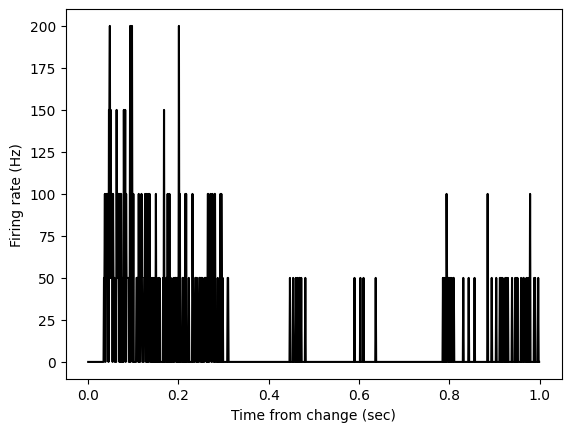

In [57]:
# Plot the PSTH
fig,ax = plt.subplots()
ax.plot(bins,unit_psth,'k')
ax.set_xlabel('Time from change (sec)')
ax.set_ylabel('Firing rate (Hz)')


# SESSION 2

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

## Getting reward, pupil, running and licking data
    
Now let's grab the reward, licking, running and pupil tracking data for this session and align them to a common time point. We'll use the time of one of the rewards to align the data.

In [58]:
#Let's get the four behavior data frames
rewards = session.rewards
eye_tracking = session.eye_tracking
running_speed = session.running_speed
licks = session.licks

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

**Reward dataframe**: The timestamps and water volumes for every reward given to the mouse. The `auto_rewarded` column is True for the first three change trials, when the reward is automatically given to the mouse to kick-start the behavior session. After that, the mouse must earn rewards by licking after a change in the reward window.

In [59]:
rewards.head()

,volume,timestamps,auto_rewarded
0,0.005,44.87655,True
1,0.005,64.39291,True
2,0.005,80.90632,True
3,0.003,119.55534,False
4,0.003,130.28088,False


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Let's grab a random reward to align the rest of the behavior data to:

In [60]:
reward_time = rewards.timestamps.iloc[10]

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

**Running dataframe**: One entry for each read of the analog input line monitoring the encoder voltage, recorded at ~60 Hz. `speed` is in units cm/s. 

In [61]:
running_speed.head()

,timestamps,speed
0,24.21123,-0.025043
1,24.22482,11.007905
2,24.24165,21.528507
3,24.25821,31.042079
4,24.27497,39.117779


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    <p> Let's cut out a snippet of the running speed in a window 3 seconds before and after our <code>reward_time</code>.
</div>

In [62]:
# grab the pupil data corresponding to our window
time_before = 3.0 #how much time to plot before the reward
time_after = 3.0 #how much time to plot after the reward

#Get running data aligned to this reward
trial_running = running_speed[(running_speed['timestamps']>=reward_time-time_before)&
                              (running_speed['timestamps']< reward_time+time_after)]

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    <p>Now we can plot this running trace together with the reward for reference.
</div>

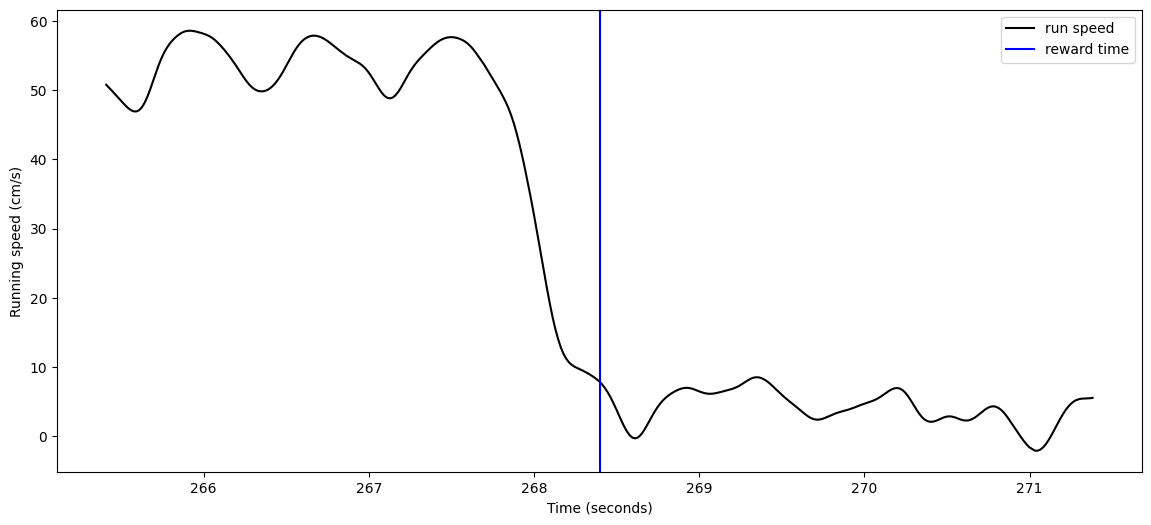

In [63]:
# plot the running
fig, ax_running = plt.subplots()
fig.set_size_inches(14,6)
ax_running.plot(trial_running['timestamps'], trial_running['speed'], 'k')

# label our axes
ax_running.set_xlabel('Time (seconds)')
ax_running.set_ylabel('Running speed (cm/s)')

# now plot the reward
ax_running.axvline(reward_time, color='b') #use axvline to plot a vertical line
ax_running.legend(['run speed', 'reward time'])

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

**Eye tracking dataframe**: One entry containing ellipse fit parameters for the eye, pupil and corneal reflection for every frame of the eye tracking video stream. These fits are the result of a [DeepLabCut](http://www.mackenziemathislab.org/deeplabcut) model trained on these eye features.

In [64]:
eye_tracking.head()

,timestamps,cr_area,eye_area,pupil_area,likely_blink,pupil_area_raw,cr_area_raw,eye_area_raw,cr_center_x,cr_center_y,...,eye_center_x,eye_center_y,eye_width,eye_height,eye_phi,pupil_center_x,pupil_center_y,pupil_width,pupil_height,pupil_phi
frame,,,,,,,,,,,,,,,,,,,,,
0,1.36447,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.38113,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.39780,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.41446,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.43113,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

There seem to be several rows for which there are no valid data. We can use the 'likely_blink' column to filter these out. This column indicates frames where the eye or pupil failed to fit or where the z-scored value of the eye or pupil area exceeds 3. In addition, two frames before and after each such likely_blink frame are also labeled likely_blink to avoid fits to partially closed or obstructed eye images.

In [65]:
eye_tracking_noblinks = eye_tracking[~eye_tracking['likely_blink']]
eye_tracking_noblinks.head()

,timestamps,cr_area,eye_area,pupil_area,likely_blink,pupil_area_raw,cr_area_raw,eye_area_raw,cr_center_x,cr_center_y,...,eye_center_x,eye_center_y,eye_width,eye_height,eye_phi,pupil_center_x,pupil_center_y,pupil_width,pupil_height,pupil_phi
frame,,,,,,,,,,,,,,,,,,,,,
18,1.68114,124.496878,80242.785195,16745.289582,False,16745.289582,124.496878,80242.785195,319.022720,250.040195,...,299.845062,243.459515,170.130669,150.132084,-0.117730,314.825135,228.266183,73.008159,68.378221,0.394571
19,1.69781,123.635359,79751.038277,16714.291578,False,16714.291578,123.635359,79751.038277,319.495616,250.370579,...,300.310986,243.292274,169.847920,149.460434,-0.097911,314.511686,228.197930,72.940553,67.705300,0.428495
20,1.71446,126.786150,80047.938510,17011.966515,False,17011.966515,126.786150,80047.938510,319.370721,250.517232,...,300.324160,243.947900,169.934887,149.940078,-0.087952,314.455601,228.205356,73.587208,68.166068,0.423260
21,1.73113,125.499820,80455.812438,16980.668668,False,16980.668668,125.499820,80455.812438,319.460923,250.304993,...,300.694063,243.883540,170.484281,150.218427,-0.088550,314.077673,228.185581,73.519485,67.545130,0.460218
22,1.74780,125.322643,80325.325277,17062.517640,False,17062.517640,125.322643,80325.325277,318.788323,249.441627,...,300.010309,243.120696,170.311250,150.127165,-0.108505,314.283247,227.043133,73.696459,67.493397,0.442226


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    <p><b>Task 5.1:</b>  Grab the pupil area data from <code>eye_tracking_noblinks</code> in the same window around our reward time as we did for the running. Plot it as we did the running.
</div>

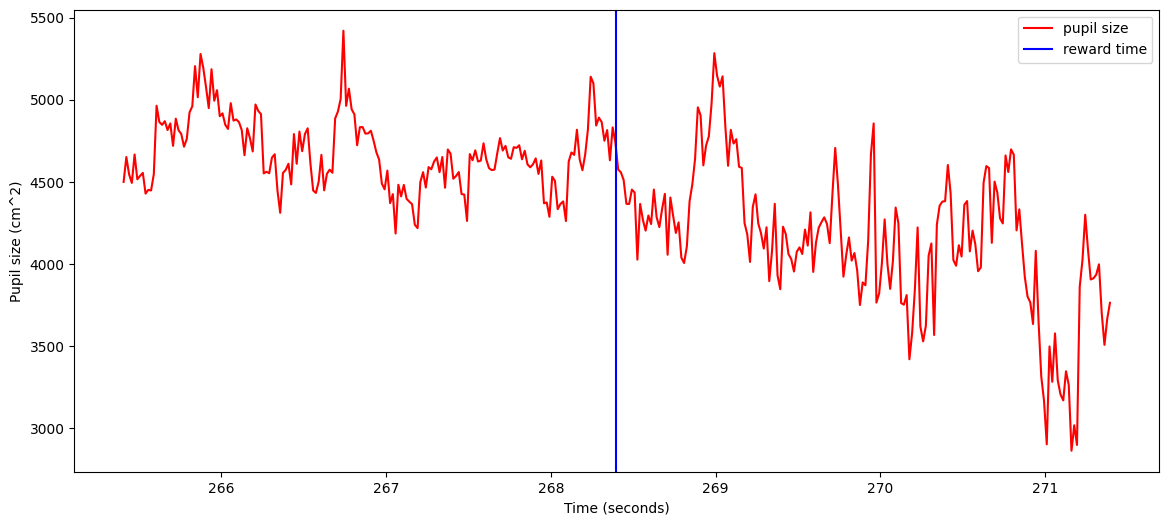

In [71]:
# First make a dataframe to store the eye tracking data in our time window

# grab the pupil data corresponding to our window
time_before = 3.0 #how much time to plot before the reward
time_after = 3.0 #how much time to plot after the reward

#Get pupil data aligned to this reward
trial_eye_tracking_data = eye_tracking_noblinks[(eye_tracking_noblinks['timestamps']>=reward_time-time_before)&
                              (eye_tracking_noblinks['timestamps']< reward_time+time_after)]

# Now plot the pupil_area column for this dataframe. Use the timestamps column for your x values
# plot the pupil
fig, ax_pupil = plt.subplots()
fig.set_size_inches(14,6)
ax_pupil.plot(trial_eye_tracking_data['timestamps'], trial_eye_tracking_data['pupil_area'], 'r')

# label our axes
ax_pupil.set_xlabel('Time (seconds)')
ax_pupil.set_ylabel('Pupil size (cm^2)')

# now plot the reward
ax_pupil.axvline(reward_time, color='b') #use axvline to plot a vertical line
ax_pupil.legend(['pupil size', 'reward time'])


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

**Licking dataframe**: One entry for every detected lick onset time.

In [72]:
licks.head()

,timestamps,frame
0,25.72309,91
1,25.85921,100
2,28.01198,229
3,32.39186,491
4,35.52050,679


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    <p><b>Task 5.2:</b> Now plot the licking data in this window. Plot the licks as magenta dots with 0 for the y coord. </div>

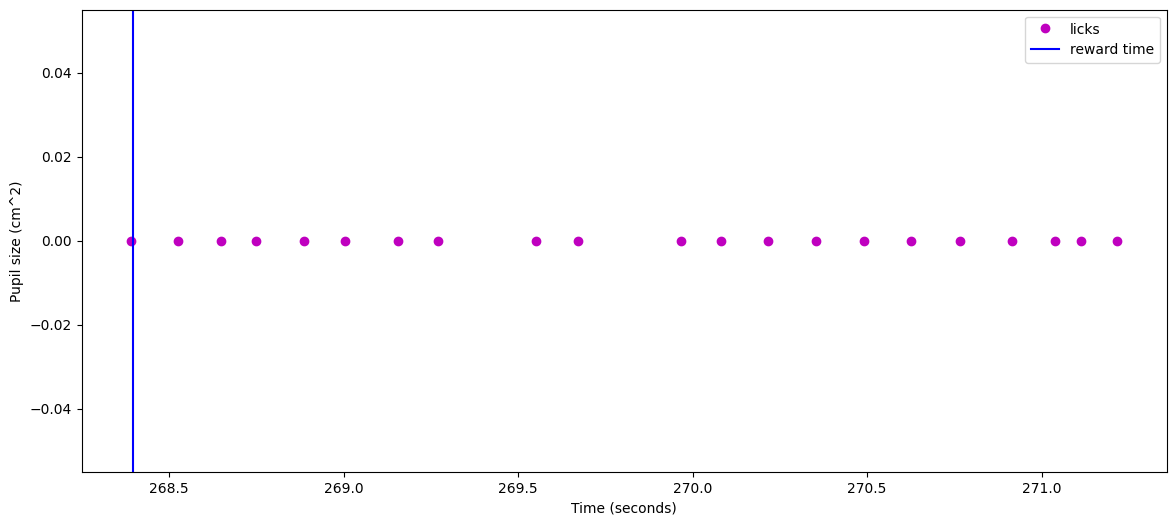

In [75]:
#Get licking aligned to this reward
time_before = 3.0 #how much time to plot before the reward
time_after = 3.0 #how much time to plot after the reward
trial_licking = licks[(licks['timestamps']>=reward_time-time_before)&
                        (licks['timestamps']< reward_time+time_after)]

# plot the licks
fig, ax_licks = plt.subplots()
fig.set_size_inches(14,6)
ax_licks.plot(trial_licking['timestamps'], np.zeros(len(trial_licking['timestamps'])), 'mo')

# label our axes
ax_licks.set_xlabel('Time (seconds)')
ax_licks.set_ylabel('Pupil size (cm^2)')

# now plot the reward
ax_licks.axvline(reward_time, color='b') #use axvline to plot a vertical line
ax_licks.legend(['licks', 'reward time'])



<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Below, we'll put all of these plots together, and add bars to denote the stimulus presentation times:

Text(0.5, 1.0, 'Single trial change-aligned running speed, pupil size, licks, and rewards')

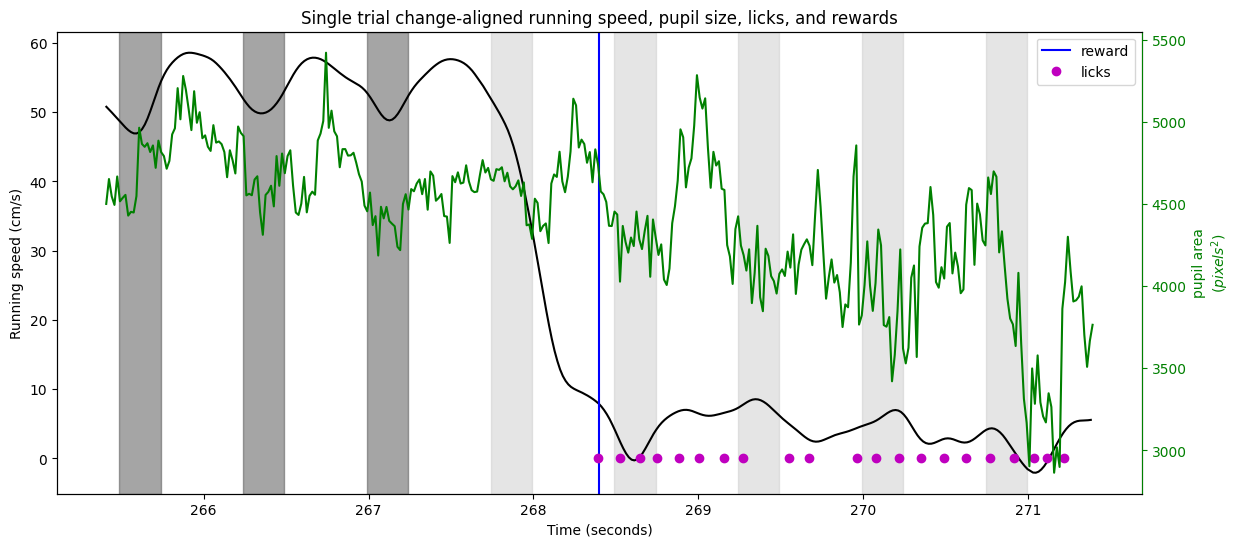

In [76]:
# Plot the running
fig, ax_running = plt.subplots()
fig.set_size_inches(14,6)
ax_running.plot(trial_running['timestamps'], trial_running['speed'], 'k')

# now plot the reward
rew_handle = ax_running.axvline(reward_time, color='b')

# label our axes
ax_running.set_xlabel('Time (seconds)')
ax_running.set_ylabel('Running speed (cm/s)')

# Plot the pupil area on a new axis with the same x-axis as the running data
ax_pupil = ax_running.twinx()
ax_pupil.plot(trial_eye_tracking_data['timestamps'], trial_eye_tracking_data['pupil_area'], 'g')
ax_pupil.set_ylabel('pupil area\n$(pixels^2)$')

# format the pupil axis to match the plot color
ax_pupil.yaxis.label.set_color('g')
ax_pupil.spines['right'].set_color('g')
ax_pupil.tick_params(axis='y', colors='g')

# Plot the licking. Just use the running axis.
lick_handle, = ax_running.plot(trial_licking['timestamps'], np.zeros(len(trial_licking['timestamps'])), 'mo')


#Now add a legend to label the reward and licks
ax_running.legend([rew_handle, lick_handle], ['reward', 'licks'])


#Plot the image flashes as grey bars. 
#Get stimulus presentations around this reward
behavior_presentations = stimulus_presentations[stimulus_presentations['active']]
trial_stimuli = behavior_presentations[(behavior_presentations['start_time']>=reward_time-time_before)&
                      (behavior_presentations['start_time'] < reward_time+time_after)]

#Specify different colors for the 2 images shown in this window
colors = ['0.3', '0.8']
stimulus_colors = {stim: c for stim,c in zip(trial_stimuli['image_name'].unique(), colors)}
for idx, stimulus in trial_stimuli.iterrows():
    ax_running.axvspan(stimulus['start_time'], stimulus['stop_time'], color=stimulus_colors[stimulus['image_name']], alpha=0.5)
    
ax_running.set_title('Single trial change-aligned running speed, pupil size, licks, and rewards')

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

## How does novelty impact visual responsiveness in VISp?

### Plotting visual responses to novel and familiar images
    
Below, we'll try to answer whether units in VISp are modulated by stimulus novelty. First we'll need a way to identify which images are novel to the mouse.

Image novelty depends on whether a mouse has previously encountered an image during training. Even in the novel image set, 2 images are shared with the training set and therefore familiar. Moreover, some mice train with image set `G` and some with image set `H`, meaning which images are novel depends on all these factors. This can be tricky to sort out, so we have provided a convenient function that will add columns to the stimulus presentations table that indicate which image set a particular image is from (unique to `G`, unique to `H` or shared across both image sets), along with whether it was novel to the mouse during that session.

In [77]:
def getImageNovelty(image_name, sessionID, ecephys_sessions_table):
    '''
    Function to help annotate the stimulus_presentations table
    to indicate the following info:
        1) whether a given image was:
            a) unique to the G set
            b) unique to the H set
            c) shared across G and H
            d) omitted
        2) whether the image was novel to the mouse
    
    Meant to be run on the image names of the stimulus_presentations table
    
    OUTPUT:
        Tuple indicating (image_set, image_novelty) for this image

    '''
    session_id = session.metadata['ecephys_session_id']
    is_novel_image_set = ecephys_sessions_table.loc[session_id]['experience_level'] == 'Novel'

    IMAGE_GROUP_KEY={
                'G' : ['im012_r', 'im036_r', 'im044_r', 
                    'im047_r', 'im078_r', 'im115_r'],
                'H' : ['im005_r', 'im024_r', 'im034_r', 
                    'im087_r', 'im104_r', 'im114_r'],
                'shared' : ['im083_r', 'im111_r'],
                'omitted' : ['omitted']
                }
    
    # First check that this image is one of the Natural Images used
    image_in_image_set = any([np.isin(image_name, imset) \
                              for _,imset in IMAGE_GROUP_KEY.items()]) 
    if not image_in_image_set:
        return np.nan

    #Get the image set for this image
    image_set_for_this_image = [name for name, image_set in IMAGE_GROUP_KEY.items()\
                                if image_name in image_set][0]
    
    #Get the image novelty for this image
    if image_set_for_this_image == 'omitted':
        novelty_for_this_image = np.nan
    else:
        novelty_for_this_image = (is_novel_image_set) and \
                            (np.isin(image_set_for_this_image, ['G', 'H']))
    

    return bool(novelty_for_this_image)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Now let's apply that function to our stimulus_presentations table and add the new columns indicating image novelty

In [78]:
is_novel = []
for rowindex, row in stimulus_presentations.iterrows():
    is_this_image_novel = getImageNovelty(row['image_name'], session_id, ecephys_sessions_table)
    is_novel.append(is_this_image_novel)

stimulus_presentations['is_novel'] = is_novel

/Users/christinejunhuiliu/opt/anaconda3/envs/swdb2022/lib/python3.8/site-packages/numpy/lib/arraysetops.py:608: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

**Note**: we could also do this by using pandas apply:

In [84]:
is_novel = stimulus_presentations.apply(lambda row: getImageNovelty(row['image_name'], 
                                                                    session_id, ecephys_sessions_table), axis=1)  
stimulus_presentations['is_novel'] = is_novel

/Users/christinejunhuiliu/opt/anaconda3/envs/swdb2022/lib/python3.8/site-packages/numpy/lib/arraysetops.py:608: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [85]:
stimulus_presentations[120:130][['is_novel', 'image_name']]

,is_novel,image_name
stimulus_presentations_id,,
120,False,im111_r
121,False,im111_r
122,False,im111_r
123,False,im111_r
124,False,im111_r
125,True,im104_r
126,True,im104_r
127,True,im104_r
128,True,im104_r


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    <p><b>Task 6.1:</b> Grab the active behavior portion of this updated stimulus table. Call the new table <code>task_stim_table</code>
</div>

In [94]:
#Grab the portion of the stim table that describes the active behavior stimuli
task_stim_table = stimulus_presentations[stimulus_presentations['active']]


<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
This table stores all of the stimulus info we'll need to make our PSTHs for novel and familiar change stimuli. Now we'll need to get the unit spiking data and organize it into a useful format.  
  
<p>
<p>For this (and other) analyses, organizing the data into a 3D array can make things much more convenient. This 3D array will have shape (neurons, trial time, trials) and will store the spike counts for every neuron and time bin in every trial. For our purposes, we will define a trial as an image presentation (ie, every flash in the stim table will be one 'trial' for our array). So our array will be of shape (neurons in V1, flash time, number of image flashes).

<img src="https://brainmapportal-live-4cc80a57cd6e400d854-f7fdcae.divio-media.net/filer_public/8e/45/8e4554f8-029f-43dd-badd-32d77d48898a/tensor_diagram.png"
     width="400" 
     height="500" />
     
Williams et al. (2018). Neuron, 98(6): 1099-1115

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

To make this 3D array, first we'll need to get the spike times for VISp units during this experiment:

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    <p><b>Task 6.2:</b> Filter the units dataframe for only good units. Use the following quality criteria:
            <p> &emsp; 1) <code>quality</code> == 'good'
            <p> &emsp; 2) <code>snr</code> > 1
            <p> &emsp; 3) <code>isi_violations</code> < 1  
            <p> Call this new dataframe <code>good_units</code>                                    
</div>

In [102]:
# Filter units by the quality criteria

good_units = units[(units.quality == 'good') &
                  (units.snr > 1) &
                  (units.isi_violations < 1)]
good_units.shape

(1158, 34)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Now let's grab the good units in VISp by filtering on the structure_acronym column

In [100]:
visp_units = good_units[good_units['structure_acronym']=='VISp']
visp_units.shape

(49, 34)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

We've provided a function to help make our 3D array. Let's look at it below:

In [103]:
def make_neuron_time_trials_array(units, spike_times, stim_table, 
                                   time_before, trial_duration,
                                   bin_size=0.001): #bin_size is 1 msec
    '''
    Function to make a 3D array with dimensions [neurons, time bins, trials] to store
    the spike counts for stimulus presentation trials. 
    INPUTS:
        units: dataframe with unit info (same form as session.units table)
        stim_table: dataframe whose indices are trial ids and containing a
            'start_time' column indicating when each trial began
        time_before: seconds to take before each start_time in the stim_table
        trial_duration: total time in seconds to take for each trial
        bin_size: bin_size in seconds used to bin spike counts 
    OUTPUTS:
        unit_array: 3D array storing spike counts. The value in [i,j,k] 
            is the spike count for neuron i at time bin j in the kth trial.
        time_vector: vector storing the trial timestamps for the time bins
    '''
    # Get dimensions of output array
    neuron_number = len(units)
    trial_number = len(stim_table)
    num_time_bins = int(trial_duration/bin_size)
    
    # Initialize array
    unit_array = np.zeros((neuron_number, num_time_bins, trial_number))
    
    # Loop through units and trials and store spike counts for every time bin
    for u_counter, (iu, unit) in enumerate(units.iterrows()):
        
        # grab spike times for this unit
        unit_spike_times = spike_times[iu]
        
        # now loop through trials and make a PSTH for this unit for every trial
        for t_counter, (it, trial) in enumerate(stim_table.iterrows()):
            trial_start = trial.start_time - time_before
            unit_array[u_counter, :, t_counter] = makePSTH(unit_spike_times, 
                                                            [trial_start], 
                                                            trial_duration, 
                                                            binSize=bin_size)[0]
    
    # Make the time vector that will label the time axis
    time_vector = np.arange(num_time_bins)*bin_size - time_before
    
    return unit_array, time_vector

In [104]:
#Make 3D data array
time_before_flash = 1.0 # 1 sec before flash for baseline
trial_duration = 2.0 #2 secs after the first flash - this will include more than one flash
bin_size = 0.001
flash_stim_array, time = make_neuron_time_trials_array(visp_units, spike_times,
                                                       task_stim_table, time_before_flash, 
                                                       trial_duration)
# visp_units: the good units in the visp units
# spike_times is a dictionary
# task_stim_table: active behavior of the task

In [105]:
flash_stim_array.shape

(49, 2000, 4804)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Now let's use our 3D array to find the change responses to novel and familiar images. We'll do this by: 

1) finding the trial ids for our trials of interest, and  
    2) Using those ids to index the 'trials' dimension of <code>flash_stim_array</code>


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    <p><b>Task 6.3:</b> Get the trial ids for the famliar and novel image changes. We'll need to:
       <p>&emsp; 1) Filter the <code>task_stim_table</code> for changes (using <code>is_change</code>)
       <p>&emsp; 2) Find the novel and familiar changes (using our new <code>is_novel</code> column). Store these in two new dataframes called <code>novel_change_flashes</code> and <code>familiar_change_flashes</code> 
       <p>&emsp; 3) Find the indices in our 3D array that correspond to the novel/familiar change stimuli
           
</div>

In [106]:
# Filter the task_stim_table for change stimuli
change_flashes = task_stim_table[task_stim_table.is_change]

In [128]:
# make the novel_changes and familiar_changes dataframes
novel_change_flashes = change_flashes[change_flashes.is_novel==True]
familiar_change_flashes = change_flashes[change_flashes.is_novel==False]

In [129]:
familiar_change_flashes.shape

(75, 22)

In [131]:
# Find indices for novel and familiar change flashes in our 3D array
novel_flash_ids = novel_change_flashes.index #Hint: These should be the index values or the novel_change_flashes dataframe
novel_array_indices = task_stim_table.index.get_indexer(novel_flash_ids)

familiar_flash_ids = familiar_change_flashes.index
familiar_array_indices = task_stim_table.index.get_indexer(familiar_flash_ids)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Now we can use these indices to plot the PSTHs across V1 for familiar and novel change stimuli!


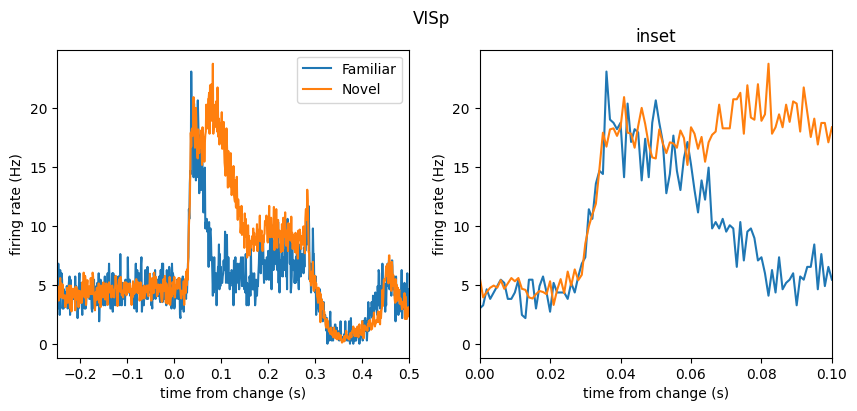

In [132]:
fig, axes = plt.subplots(1,2)
fig.set_size_inches([10, 4])
fig.suptitle('VISp')

# Loop through our familiar and novel array indices
for array_flash_indices in [familiar_array_indices, novel_array_indices]:
    
    # Use these indices to select the corresponding data from our data array
    relevant_trials = flash_stim_array[:, :, array_flash_indices]
    
    # We can use numpy mean to average over units and trials (the 0th and 2nd dimension of our array)
    mean_over_neurons_trials = np.mean(relevant_trials, axis=(0, 2))
    
    # Now plot. We're plotting twice to show two time scales.
    xlims = ([-0.25, 0.5], [0, 0.1])
    for ax, xlim in zip(axes, xlims):
        ax.plot(time, mean_over_neurons_trials)
        ax.set_xlim(xlim)
        ax.set_xlabel('time from change (s)')
        ax.set_ylabel('firing rate (Hz)')

axes[1].set_title('inset')
axes[0].legend(['Familiar', 'Novel'])

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

# How does novelty impact mouse behavior?
    
It looks like novelty can have a pretty dramatic impact on VISp visual responses. What about the behavior of the mouse? Let's calculate hit rates for novel and familiar changes during this session.
    
## Calculating hit rates for novel and familiar images
    
Let's use the trials table to calculate the hit rates for the novel and familiar images. First, we'll need to annotate the trials dataframe so we know which trials had novel and familiar change stimuli.

In [ ]:
#First, let's annotate the trials by the novelty of their change image using the getImageNovelty function
is_novel = trials.apply(lambda row: getImageNovelty(row['change_image_name'], session_id, 
                                                    ecephys_sessions_table), axis=1)

trials['is_novel_change_image'] = is_novel

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    <p><b>Task 7.1:</b> Filter the trials table for <code>go</code> trials, since these are the ones with change stimuli. Call the new dataframe <code>go_trials</code>.
           
</div>

In [ ]:
go_trials = ?

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    <p><b>Task 7.2:</b> Use the <code>groupby</code> method on the <code>change_image_name</code> column to:
       <p> 1) count the total number of go trials for each image
       <p> 2) count the total number of hits for each image
    <p> You can accomplish both of these with one line. It will look like:
    <p> <code>go_trials.groupby(?).agg(?)</code>
    <p> What column name should go in the first '?'
    <p> What function should go in the second '?'
    <p> Store the results in a dataframe called <code>image_go_data</code>
           
</div>

In [ ]:
image_go_data = go_trials.groupby(?).agg(?)
image_go_data

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
As you can see, many of these columns aren't very meaningful. Let's select only the <code>stimulus_change</code>, <code>hit</code> and <code>is_novel_change_image</code> columns to make this dataframe easier to work with:

In [ ]:
image_go_data = image_go_data[['stimulus_change', 'hit', 'is_novel_change_image']]
image_go_data

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
Let's clean this dataframe up a bit by setting all of the rows with <code>is_novel_change_image</code>>0 to <code>True</code> and <code>is_novel_change_image</code>==0 to <code>False</code>
</div>

In [ ]:
image_go_data.loc[image_go_data['is_novel_change_image']>0, 'is_novel_change_image'] = True
image_go_data.loc[image_go_data['is_novel_change_image']==0, 'is_novel_change_image'] = False

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
    <p><b>Task 7.3:</b> Use this new table to calculate the hit rates for every image. Store these in a new column called <code>hit_rate</code>.
</div>

In [ ]:
hit_rates = ?
image_go_data['hit_rate'] = hit_rates

In [ ]:
# We can display the results with cells color-coded by their hit rate to make it easier to see what's going on here
display(image_go_data.style.background_gradient(cmap='bwr', subset='hit_rate'))

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
Now let's plot this data. 
</div>

In [ ]:
fig = plt.figure()
fig.set_size_inches(14, 6)
gs = GridSpec(2, 8, figure=fig)

hit_rate_ax = fig.add_subplot(gs[0, :])
colors = ['r', 'b']
image_order = []
for isnovel, color in zip([True, False], colors):
    rows = image_go_data[image_go_data['is_novel_change_image']==isnovel]
    rows = rows.sort_values('hit_rate', ascending=False)
    
    hit_rates = rows['hit_rate']
    hit_rate_ax.plot(hit_rates, color+'o-')
    
    image_order.extend(rows.index.values)
    
hit_rate_ax.set_ylabel('Hit Rate')
hit_rate_ax.legend(['Novel', 'Familiar'])

# Let's add the images themselves under each dot.    
for ind, im in enumerate(image_order):
    im_ax = fig.add_subplot(gs[1, ind])
    im_ax.imshow(session.stimulus_templates['warped'][im], cmap='gray')
    im_ax.axes.xaxis.set_visible(False)
    im_ax.axes.yaxis.set_visible(False)
